# Stack Overflow Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
import time
from matplotlib.pyplot import GridSpec
from sklearn.metrics import f1_score

In [2]:
filename = '/Dataset/2016 Stack Overflow Survey Responses.csv'

In [3]:
# Let's preview dataset
from os import getcwd, listdir, chdir

df = pd.read_csv(getcwd() + filename)

def reset_df():
    """This function reverts the dataset into the original"""
    global df
    df = pd.read_csv(getcwd() + filename)
    
print df.shape
print df.head()

(56030, 66)
   Unnamed: 0 collector      country   un_subregion     so_region age_range  \
0        1888  Facebook  Afghanistan  Southern Asia  Central Asia     20-24   
1        4637  Facebook  Afghanistan  Southern Asia  Central Asia     30-34   
2       11164  Facebook  Afghanistan  Southern Asia  Central Asia       NaN   
3       21378  Facebook  Afghanistan  Southern Asia  Central Asia       NaN   
4       30280  Facebook  Afghanistan  Southern Asia  Central Asia      > 60   

   age_midpoint                  gender  \
0          22.0                    Male   
1          32.0                    Male   
2           NaN                     NaN   
3           NaN                  Female   
4          65.0  Prefer not to disclose   

                                 self_identification              occupation  \
0                                         Programmer                     NaN   
1                    Developer; Engineer; Programmer  Mobile developer - iOS   
2             

In [4]:
# I'd like to observe an arbitrary column and analyze the categories within
c = 'education'
df[c].groupby(df[c]).count()

education
B.A. in Computer Science (or related field)                                                                                                                                                                                                                                 701
B.A. in Computer Science (or related field); B.S. in Computer Science (or related field)                                                                                                                                                                                     68
B.A. in Computer Science (or related field); B.S. in Computer Science (or related field); Masters Degree in Computer Science (or related field)                                                                                                                              13
B.A. in Computer Science (or related field); B.S. in Computer Science (or related field); Masters Degree in Computer Science (or related field); PhD in Computer Science (or r

# Understanding the columns and extracting the target columns for predictions

## There are a few things I'd like to do for a general plan:

1 Look at and understand the data

2 Break the dataset into a few mini projects, first starting with one mini project. 

3 Take a few columns as features, and use them for as the target column for each prediction

4 Mine and separate useful data into features to make different predictions:

    prediction 1 will use feature columns A - E
    
    prediction 2 will use feature columns F - P
    
    prediction 3 will use feature columns Q - X
    
4 Find patterns in the data, then trim the dataset as needed to find more patterns in the data

5 Make predictions, such as predict if a person is looking for a new job, and contact them.


example columns to use for the first prediction: 
'open_to_new_job', 'open_to_new_job', 'new_job_value', 'agree_loveboss', 'important_variety', 'important_newtech'

I'd like to understand more about the people who are currently working. Can we determine groups of people and their personalities, based on the importance of the workplace questions? From there, can we determine if those different types of people are looking for a new job? Can an ideal company be created to optimize worker happiness (of course, there are tradeoffs)?

By looking at the columns, I'll choose features that I think are important and list the reasons alongside them.
'age_range'           - does age determine if the person is looking for a                         new job?
'experience_range'    - does their level of experience encourage them to                           hop around to different companies?
'programming_ability' - this is not just a measure of their perceived                             ability but also a measure of their confidence 
'agree_loveboss'      - can they tolerate their bosses easily
'important_variety'   - would they rather switch roles often or do they                           prefer to stay with a specialty
'important_control'   - i hypothesize that this relates to b
'important_promotion' - do they care about promotions? i know some would                           rather be coding
'important_newtech'   - 
'important_companymission' - do they care about this much?
'important_buildexisting' - i think this would be the opposite of working                             with a variety of projects
'important_buildnew'  - build new?
'important_wfh'       - would this really matter?
'developer_challenges'- are there certain things that developers could do                         without?
'new_job_value'       - important about new employment opportunity, this                           is important to know
'tech_want'           - 
'education'           - 
'industry'            - 
'agree_notice'        - this shows how some brains work
'agree_nightcode'     - because these guys are a different type of animal
'occupation'          - 

I'm going to combine these to create a new dataframe then use the .dropna() function to remove unnecessary data to see if the data isn't reduced down too much.

From there, we will use PCA for feature extraction in order to focus on the really important ones

Process:
• Combine data into one DataFrame
• drop entries and columns with too many NaN values
• features: expand certain features
• label: vectorize the entries

In [33]:
# Combine all columns into one dataframe
work_xp = ['age_range', 'experience_range', 'programming_ability', 'agree_loveboss',
           'important_variety', 'important_control', 'important_promotion',
           'important_newtech', 'important_companymission', 'important_buildexisting',
           'important_buildnew', 'important_wfh', 'developer_challenges',
           'new_job_value', 'education', 'occupation', 'open_to_new_job']

# create a dataframe template
work_xp_df = pd.DataFrame(index=df.index)

# combine the selected columns into the new dataframe
for col in work_xp:
    work_xp_df = pd.concat([work_xp_df, df[col]], axis=1)
    
original = work_xp_df
original_shape = work_xp_df.shape # shape before dropping NaN entries

# # NaN values

use KNN to fill in the missing NaN values
5620 rows have only 1 NaN value
666, 2
and 115, 3

If the row has less than 4 NaN entries, find its 5 nearest neighbors
For each of the NaN entries, get a majority vote of the nearest neighbors
If there is no majority vote then choose the mean of the entire dataset


In [37]:
# remove rows with more than 3 NaN entries
work_xp_df = work_xp_df.dropna(thresh=(min(*work_xp_df.shape) - 3))

reduced = work_xp_df.shape # shape after dropping NaN entries
# equation to calculate the percent change
percent_change = float((original_shape[0] - reduced[0])) / float(original_shape[0]) * 100
print "Using the .dropna() function reduces the data by {:.2f}% to these dimensions {}\n".format(percent_change, reduced)

print "Number of NaN entries per column: "
for col in original:
    print col, pd.isnull(original[col]).sum()

# I'd like to come back to this, and see if the ML algos can use this dataset with NaN values
work_xp_df

Using the .dropna() function reduces the data by 23.97% to these dimensions (42598, 17)

Number of NaN entries per column: 
age_range 303
experience_range 6510
programming_ability 9048
agree_loveboss 13934
important_variety 13402
important_control 13458
important_promotion 13547
important_newtech 13426
important_companymission 13501
important_buildexisting 13450
important_buildnew 13492
important_wfh 13448
developer_challenges 14934
new_job_value 12372
education 11075
occupation 6511
open_to_new_job 11650


,age_range,experience_range,programming_ability,agree_loveboss,important_variety,important_control,important_promotion,important_newtech,important_companymission,important_buildexisting,important_buildnew,important_wfh,developer_challenges,new_job_value,education,occupation,open_to_new_job
1,30-34,6 - 10 years,7.0,Agree somewhat,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,I don't care about this,This is very important,I don't care about this,Unrealistic expectations; Interacting with non...,Salary; Ability to make or influence important...,I'm self-taught; On-the-job training; B.S. in ...,Mobile developer - iOS,I am not interested in new job opportunities
3,NaN,11+ years,8.0,Disagree completely,This is somewhat important,I don't care about this,I don't care about this,This is somewhat important,I don't care about this,This is very important,This is very important,This is very important,Corporate policies; Interacting with non-techn...,Office location; Remote working option; Flexib...,I'm self-taught; On-the-job training,DevOps,"I'm not actively looking, but I am open to new..."
7,25-29,1 - 2 years,7.0,Agree completely,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,I don't care about this,Non-technical management; Poor infrastructure ...,Salary; Company size; Job title,B.S. in Computer Science (or related field),Back-end web developer,"I'm not actively looking, but I am open to new..."
9,20-24,1 - 2 years,3.0,Neutral,This is very important,This is somewhat important,This is very important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor documentation,Tech stack; Opportunity for advancement,I'm self-taught; On-the-job training; Online c...,Back-end web developer,"I'm not actively looking, but I am open to new..."
11,20-24,6 - 10 years,9.0,Agree completely,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company stage; Work/life balance; Oppo...,"I'm self-taught; Online class (e.g. Coursera, ...",Full-stack web developer,"I'm not actively looking, but I am open to new..."
12,25-29,6 - 10 years,7.0,Neutral,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor scheduling; Interacting with stupid peopl...,Salary; Opportunity for advancement; Job title,B.S. in Computer Science (or related field),Full-stack web developer,I am actively looking for a new job
13,25-29,6 - 10 years,8.0,Disagree somewhat,This is somewhat important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company size; Company financials; Work...,I'm self-taught; On-the-job training; Masters ...,Back-end web developer,I am actively looking for a new job
14,20-24,1 - 2 years,7.0,Agree completely,I don't care about this,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,Trying to be nice,Salary; Equity; Ability to make or influence i...,I'm self-taught; On-the-job training,Back-end web developer,I am not interested in new job opportunities
19,25-29,6 - 10 years,9.0,Neutral,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is very important,This is very important,This is very important,This is somewha

In [41]:
# Analyzing each row's number of NaN entries
from sklearn.preprocessing import Imputer

count = {}

for row, data in work_xp_df.iterrows():
    no_nan = data.isnull().sum()
    
#     if no_nan > 3:
#         print no_nan
    
    if no_nan in count:
        count[no_nan] += 1
    else:
        count[no_nan] = 1
        
for i, j in count.iteritems():
    print "{} rows have {} NaN values".format(j, i)

36197 rows have 0 NaN values
5620 rows have 1 NaN values
666 rows have 2 NaN values
115 rows have 3 NaN values


## Here are the results of the number of NaN entries per column

I went back and changed the thresh parameter on the dropna() function to 3. 

36197 rows have 0 NaN values
5620 rows have 1 NaN values
666 rows have 2 NaN values
115 rows have 3 NaN values
46 rows have 4 NaN values
29 rows have 5 NaN values
22 rows have 6 NaN values
29 rows have 7 NaN values
41 rows have 8 NaN values
196 rows have 9 NaN values
1243 rows have 10 NaN values
287 rows have 11 NaN values
950 rows have 12 NaN values
3884 rows have 13 NaN values
422 rows have 14 NaN values
77 rows have 15 NaN values
6036 rows have 16 NaN values
170 rows have 17 NaN values

In [42]:
# Analyzing the number of NaN values per column
i = 1
for col, data in original.iteritems():
    print "Column {}:\n\t\t\t\t\t{}".format(col, data.isnull().sum())
    i += 1

Column age_range:
					303
Column experience_range:
					6510
Column programming_ability:
					9048
Column agree_loveboss:
					13934
Column important_variety:
					13402
Column important_control:
					13458
Column important_promotion:
					13547
Column important_newtech:
					13426
Column important_companymission:
					13501
Column important_buildexisting:
					13450
Column important_buildnew:
					13492
Column important_wfh:
					13448
Column developer_challenges:
					14934
Column new_job_value:
					12372
Column education:
					11075
Column occupation:
					6511
Column open_to_new_job:
					11650


In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from math import isnan


def five_nearest(df, row):
    five = NearestNeighbors(n_neighbors=5)
    five.fit(df)
    distances, indices = five.kneighbors(row)
    
    return indices
    
    
# fill in NaN values
def fill_nan(df):
    five_neighbors = NearestNeighbors(n_neighbors=5)
    five_neighbors.fit(df)
    
    # iterate through the rows
    for row, data in df.iterrows(): # Series
        
        # collect its neighbors (potential BUG: neighbors themselves have a lot of NaN entries)
        dist, n_indices = five_neighbors.kneighbors(df.iloc[row])
#             # selecting indices of NaN entries
#             for i, b in enumerate((data.iloc[row].isnull() == True).values.tolist()):
#                 if b == True:
# #                     df.iloc[row][i] = 
#                     imp = Imputer()
#                     neighbors_data = df.iloc[indices[0]][i]
#                     imp.fit(neighbors_data)

# five_nearest(cleaned_features.iloc[5])

dummy_df = work_xp_df[work_xp_df.columns[:-1]]
# five = NearestNeighbors(n_neighbors=5)
# five.fit(dummy_df)


le = LabelEncoder()
le.fit(work_xp_df[work_xp_df.columns[0]])
tr = le.transform(work_xp_df[work_xp_df.columns[0]])

count = {}

for i in tr:
    if i not in count:
        count[i] = 1
    else:
        count[i] += 1
        
print count

print work_xp_df[work_xp_df.columns[0]].isnull().sum()

# for row, data in dummy_df.iloc[:50].iterrows():
#     if (data.isnull().sum() > 0) and (data.isnull().sum() <=3):
#         distances, n_indices = five.kneighbors(data)
#         imp = Imputer(strategy='most_frequent', axis=0)
#         imp.fit(five)
#         neighbor_data = dummy_df.iloc[n_indices]
        
#         for i, val in enumerate(data):
#             if pd.isnull(val):
#                 # change the nan value to the most frequent neighbors answer
#                 data_mode = neighbor_data[neighbor_data.columns[i]].groupby(neighbor_data[neighbor_data.columns[i]]).count().mode()

#                 mini_df = neighbor_data[neighbor_data.columns[i]].groupby(neighbor_data[neighbor_data.columns[i]]).count()
#                 v = mini_df.index[mini_df.values == data_mode[0]][0]
                
#                 dummy_df.iloc[row][i] = v

NameError: name 'LabelEncoder' is not defined

In [ ]:
#         for i, value in enumerate(dummy_df.iloc[row]):

#             # check if its an NaN value
#             if isinstance(value, float) and isnan(value):
#                 reduced = dummy_df[dummy_df.columns[i]].groupby(dummy_df[dummy_df.columns[i]]).count()
#                 dummy_df.iloc[row][i] = reduced.index[dummy_df.index[dummy_df[dummy_df.columns[i]].groupby(dummy_df[dummy_df.columns[i]]).count() == max(reduced)][0]]
#                 dummy_df.iloc[6][6] = 1


# reduced = dummy_df[dummy_df.columns[1]].groupby(dummy_df[dummy_df.columns[1]]).count()

# print reduced.index[dummy_df.index[dummy_df[dummy_df.columns[1]].groupby(dummy_df[dummy_df.columns[1]]).count() == 15897][0]]
# print reduced.index[dummy_df.index[dummy_df[dummy_df.columns[1]].groupby(dummy_df[dummy_df.columns[1]]).count() == 15897][0]]


In [529]:
neighbor_data = dummy_df.iloc[:10]

print neighbor_data[neighbor_data.columns[1]].groupby(neighbor_data[neighbor_data.columns[1]]).count().mode()
data_mode = neighbor_data[neighbor_data.columns[1]].groupby(neighbor_data[neighbor_data.columns[1]]).count().mode()
mini_df = neighbor_data[neighbor_data.columns[1]].groupby(neighbor_data[neighbor_data.columns[1]]).count()
val = mini_df.index[mini_df.values == data_mode[0]][0]
print mini_df

0    2
dtype: int64
experience_range
1 - 2 years     2
11+ years       2
6 - 10 years    1
dtype: int64
str


In [9]:
# this updates the indices
work_xp_df.index = range(1, max(*work_xp_df.shape)+1)
work_xp_df

,age_range,experience_range,programming_ability,agree_loveboss,important_variety,important_control,important_promotion,important_newtech,important_companymission,important_buildexisting,important_buildnew,important_wfh,developer_challenges,new_job_value,education,occupation,open_to_new_job
1,30-34,6 - 10 years,7.0,Agree somewhat,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,I don't care about this,This is very important,I don't care about this,Unrealistic expectations; Interacting with non...,Salary; Ability to make or influence important...,I'm self-taught; On-the-job training; B.S. in ...,Mobile developer - iOS,I am not interested in new job opportunities
2,25-29,1 - 2 years,7.0,Agree completely,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,I don't care about this,Non-technical management; Poor infrastructure ...,Salary; Company size; Job title,B.S. in Computer Science (or related field),Back-end web developer,"I'm not actively looking, but I am open to new..."
3,20-24,1 - 2 years,3.0,Neutral,This is very important,This is somewhat important,This is very important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor documentation,Tech stack; Opportunity for advancement,I'm self-taught; On-the-job training; Online c...,Back-end web developer,"I'm not actively looking, but I am open to new..."
4,20-24,6 - 10 years,9.0,Agree completely,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company stage; Work/life balance; Oppo...,"I'm self-taught; Online class (e.g. Coursera, ...",Full-stack web developer,"I'm not actively looking, but I am open to new..."
5,25-29,6 - 10 years,7.0,Neutral,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor scheduling; Interacting with stupid peopl...,Salary; Opportunity for advancement; Job title,B.S. in Computer Science (or related field),Full-stack web developer,I am actively looking for a new job
6,25-29,6 - 10 years,8.0,Disagree somewhat,This is somewhat important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company size; Company financials; Work...,I'm self-taught; On-the-job training; Masters ...,Back-end web developer,I am actively looking for a new job
7,20-24,1 - 2 years,7.0,Agree completely,I don't care about this,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,Trying to be nice,Salary; Equity; Ability to make or influence i...,I'm self-taught; On-the-job training,Back-end web developer,I am not interested in new job opportunities
8,25-29,6 - 10 years,9.0,Neutral,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is very important,This is very important,This is very important,This is somewhat important,Poor team dynamics; Interacting with stupid pe...,Salary; Remote working option; Flexible work h...,Masters Degree in Computer Science (or related...,Desktop developer,"I'm not actively looking, but I am open to new..."
9,20-24,2 - 5 years,6.0,Agree completely,This is very important,This is very important,This is somewhat important,This is very important,This is very important,This is very important,This is very importan

# Next, split columns into features and label columns

In [10]:
# dataset of the features
feature_cols = work_xp_df.columns[:min(*work_xp_df.shape) - 1]
# dataset of the label column
label_col = work_xp_df.columns[-1]

print work_xp_df[label_col].groupby(work_xp_df[label_col]).count()

print feature_cols

open_to_new_job
I am actively looking for a new job                              5538
I am not interested in new job opportunities                     7439
I'm not actively looking, but I am open to new opportunities    23220
dtype: int64
Index([u'age_range', u'experience_range', u'programming_ability',
       u'agree_loveboss', u'important_variety', u'important_control',
       u'important_promotion', u'important_newtech',
       u'important_companymission', u'important_buildexisting',
       u'important_buildnew', u'important_wfh', u'developer_challenges',
       u'new_job_value', u'education', u'occupation'],
      dtype='object')


# The columns need to be vectorized and normalized, since they are currently formatted into categories, objects, and strings

The label column has three entries: [“I am not interested in new job opportunities”, “I’m not actively looking, but I am open to new opportunities”, “I am actively looking for a new job”]. I'd have to convert "I am not interested in new job opportunities" to have a value of 0 and the other two entries to a value of 1.

The feature columns are more complicated, since each are formatted differently. The features need to be categorized into different groups, based on how they need to be vectorized. Then we need to call a function on each of those groups to get the DataFrame's final desired format.

One challenge I'm thinking of is that the vectorized columns are unable to be inverse-transformed, meaning once ['red', 'white', 'blue'] is turned into [0, 1, 2], will we need to label the vectors ['red', 'white', 'blue'] for identifying the entries in the column.

In [126]:
# vectorize label column
mapper = {"I am not interested in new job opportunities": 0,
          "I'm not actively looking, but I am open to new opportunities": 1,
          "I am actively looking for a new job": 1}

label = pd.DataFrame(work_xp_df[label_col].map(mapper))

print label

       open_to_new_job
1                    0
2                    1
3                    1
4                    1
5                    1
6                    1
7                    0
8                    1
9                    1
10                   0
11                   0
12                   1
13                   1
14                   1
15                   1
16                   1
17                   1
18                   1
19                   1
20                   1
21                   1
22                   1
23                   1
24                   1
25                   1
26                   0
27                   1
28                   1
29                   1
30                   1
...                ...
36168                1
36169                1
36170                1
36171                1
36172                1
36173                1
36174                0
36175                1
36176                1
36177                0
36178                1
36179      

In [127]:
# before vectorizing the feature columns, we'll take a look at how all of them are formatted
features = work_xp_df[feature_cols]

print features[features.columns[0:5]]
print features.education

      age_range  experience_range  programming_ability       agree_loveboss  \
1         30-34      6 - 10 years                  7.0       Agree somewhat   
2         25-29       1 - 2 years                  7.0     Agree completely   
3         20-24       1 - 2 years                  3.0              Neutral   
4         20-24      6 - 10 years                  9.0     Agree completely   
5         25-29      6 - 10 years                  7.0              Neutral   
6         25-29      6 - 10 years                  8.0    Disagree somewhat   
7         20-24       1 - 2 years                  7.0     Agree completely   
8         25-29      6 - 10 years                  9.0              Neutral   
9         20-24       2 - 5 years                  6.0     Agree completely   
10        20-24       2 - 5 years                  9.0     Agree completely   
11         < 20  Less than 1 year                  4.0  Disagree completely   
12        20-24       2 - 5 years                  7

age_range: the age_range needs to be vectorize

experience_range: vectorize

programming_ability: vectorize

agree_loveboss: vectorize

important_variety: vectorize

important_contro: vectorize

important_companymission: vectorize

important_buildexisting: vectorize

important_buildnew: vectorize

important_wfh: vectorize

developer_challenges: convert to binary columns

new_job_value: convert to binary columns

education: convert to binary columns

occupation: vectorize

## the columns that need to be vectorized are converting the entries to numbers range(0, n)
## the columns that need to be converted to binary columns have multiple answers

We'll create two functions for these two groups

In [572]:
# this is a list of all the columns that need to be broken down further
large_columns = ["developer_challenges", "new_job_value", "education"]

In [602]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# this function uses the LabelEncoder() to convert entries into numeric values
def vectorize_data(df, col):
    # bug: dataframe entry is shifted
    le = LabelEncoder()
    le.fit(df[col])
    vectorized = le.transform(df[col])
    
    # need to shift data, so the first index is 1, not 0
    return pd.DataFrame(vectorized, columns=[col], index=range(0, max(*df.shape)))


# this function splits the multiple answers into all columns and inputs binary entries
def convert_to_binary_columns(df, column_name):
    a = df[column_name].str.get_dummies(sep='; ')
    return a


# this main function uses the converters above to transform the entire dataset
def main_transform_columns(df):
    binary_outX = pd.DataFrame(index=df.index)
    vec_outX = pd.DataFrame(index=df.index)
    binary = ["developer_challenges", "new_job_value", "education"]
    
    for col in df.columns:
        if col in binary:
            expanded_col = convert_to_binary_columns(df, col)
            binary_outX = binary_outX.join(expanded_col)
        else:
            vec_col = vectorize_data(df, col)
            vec_outX = vec_outX.join(vec_col)
            
    return binary_outX


vector_features = main_transform_columns(work_xp_df)

print vector_features

       Changing requirements  Corporate policies  Fragile code base  \
0                          0                   0                  0   
1                          1                   0                  0   
2                          0                   0                  0   
3                          0                   1                  0   
4                          0                   0                  0   
5                          0                   0                  0   
6                          0                   0                  0   
7                          0                   0                  0   
8                          0                   0                  0   
9                          0                   0                  0   
10                         0                   0                  0   
11                         1                   0                  0   
12                         1                   0                  0   
13    

In [596]:
def vectorize_data(df, col):
    # bug: dataframe entry is shifted
    le = LabelEncoder()
    le.fit(df[col])
    vectorized = le.transform(df[col])
    
    # need to shift data, so the first index is 1, not 0
    return pd.DataFrame(vectorized, columns=[col], index=range(0, max(*df.shape)))

print pd.concat([vectorize_data(work_xp_df, 'age_range'), work_xp_df['age_range']], axis=1)

      age_range               age_range
0             1                   20-24
1             3                   30-34
2             0                     NaN
3             0                     NaN
4             8                    > 60
5             1                   20-24
6             9  Prefer not to disclose
7             2                   25-29
8             2                   25-29
9             1                   20-24
10            2                   25-29
11            1                   20-24
12            2                   25-29
13            2                   25-29
14            1                   20-24
15            5                   40-49
16            2                   25-29
17            7                    < 20
18            1                   20-24
19            2                   25-29
20            1                   20-24
21            1                   20-24
22            7                    < 20
23            1                   20-24


In [574]:
work_xp_df['education'].str.get_dummies(sep='; ')

,B.A. in Computer Science (or related field),B.S. in Computer Science (or related field),"Full-time, intensive program (e.g. ""boot-camp"")",I'm self-taught,Industry certification program,Masters Degree in Computer Science (or related field),"Mentorship program (e.g. Flatiron School, GDI, etc.)",On-the-job training,"Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)",Part-time program (e.g. night school),PhD in Computer Science (or related field),Some college coursework in Computer Science (or related field)
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,1,0,0,0,1,1,0,0,0


# Benchmark

In [ ]:
def class_name(objct):
    return objct.__class__.__name__

# make bar graphs
def plot_axes(df, column_name):
    if class_name(df) == 'DataFrame':
        binary_df_sum = convert_to_binary_columns(df, column_name).sum()
    elif class_name(df) == 'Series':
        binary_df_sum = df
        
    binary_df_sum.sort_values(inplace=True, 
                                 ascending=False,
                                 na_position='first')
    x = binary_df_sum.index
    y = binary_df_sum
    
    return x, y, column_name

def plot_binary_df((x, y, column_name)):
    ind = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical', fontsize=13, horizontalalignment='left')
    pl.subplots_adjust(bottom=0.30)
    pl.show()

# plot bar graphs of each of the listed columns, using the functions above
print features.shape
for column in large_columns:
    sub_df = plot_binary_df((plot_axes(features, column)))

In [132]:
print "Feature columns:\n"
for col in cleaned_features.columns:
    print col
    
print "\n\nLabel columns:\n"
print label.columns[0]

Feature columns:

age_range
experience_range
programming_ability
agree_loveboss
important_variety
important_control
important_promotion
important_newtech
important_companymission
important_buildexisting
important_buildnew
important_wfh
Changing requirements
Corporate policies
Fragile code base
Inefficient development processes
Interacting with non-technical people
Interacting with stupid people
Limited resources
Non-technical management
Outdated technologies
Poor documentation
Poor infrastructure or equipment
Poor scheduling
Poor team dynamics
Trying to be nice
Unrealistic expectations
Unspecific requirements
Ability to make or influence important decisions
Building something that's innovative
Building something that's significant
Company culture
Company financials
Company reputation
Company size
Company stage
Equity
Flexible work hours
Health insurance
Industry
Job title
Office location
Opportunity for advancement
Quality of colleagues
Remote working option
Salary
Tech stack
Work/life

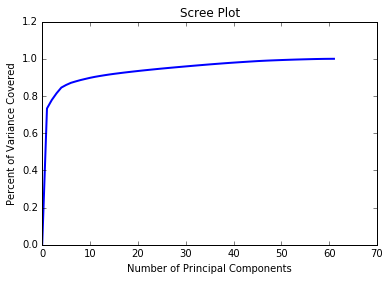

None
[ 0.73293616  0.77834572  0.81468632  0.84532528  0.8593058   0.87075286
  0.87843462  0.88556882  0.89173323  0.89774285  0.90288843  0.90739635
  0.91153059  0.9154532   0.91902837  0.92229714  0.92552754  0.9285552
  0.93149238  0.93436281  0.93712193  0.93976864  0.94237102  0.9449583
  0.94745839  0.94985018  0.95219753  0.95452745  0.9568047   0.95907116
  0.9612969   0.96348586  0.96564366  0.9677648   0.96987561  0.97187316
  0.97384586  0.97578652  0.97765307  0.97941311  0.98114004  0.98282708
  0.98446934  0.98608735  0.98765125  0.98898305  0.99021457  0.99132027
  0.99232804  0.99329572  0.99420909  0.99507828  0.99591541  0.99664659
  0.99734337  0.99802976  0.99866797  0.99914569  0.99959603  0.99984962
  1.        ]


In [133]:
# use PCA to reduce the data into lower dimensions
from sklearn.decomposition import PCA


def feature_components_evr(feature_columns):
    pca = PCA(n_components=min(*feature_columns.shape))
    pca.fit(feature_columns)
    
    return pca.components_, pca.explained_variance_ratio_
    
    
def scree_plot(evr):
    """Used to determine the number of components to use for PCA"""
    evr = np.concatenate([[0], evr])
    cum_evr = np.cumsum(evr)
    
    pl.figure()
    pl.title("Scree Plot")
    pl.plot(cum_evr, lw=2, label="Cumulative Explained Variance Ratio")
    pl.xlabel("Number of Principal Components")
    pl.ylabel("Percent of Variance Covered")
    pl.show()

fce = feature_components_evr(cleaned_features)

print scree_plot(fce[1])
print np.cumsum(fce[1])

## Based on the scree plot, above, I decided to use 3 principal components
To hypertune and modify the data later, I'll try it with 4 principal components

## Now, I'll scale and reduce the data. The data will only have the feature columns, leaving out the label column.
Before scaling, we need to take a look at the distribution of data for each column

Also, I'd like to analyze which features are correlated with each other 

In [134]:
from sklearn.preprocessing import StandardScaler

first_pc = feature_components_evr(cleaned_features)[0][0]
second_pc = feature_components_evr(cleaned_features)[0][1] 
third_pc = feature_components_evr(cleaned_features)[0][2]
fourth_pc = feature_components_evr(cleaned_features)[0][2]

cleaned_features = cleaned_features[cleaned_features.columns[:-2]]
original_data = cleaned_features
# scale to a distribution with mean = 0 and sd = 1
# bad with data that isn't normally distributed, can be a problem with categorized data that turned into vectors
# might have to change the scaling method later
scaled_data = StandardScaler().fit_transform(cleaned_features)
# reduce data, using 4 principal components
reduced_data = PCA(n_components=4).fit_transform(cleaned_features)
# reduced and scaled
reduced_scaled_data = StandardScaler().fit_transform(reduced_data)

print "Original data: {} rows, {} columns".format(*original_data.shape)
print "Scaled data: {} rows, {} columns".format(*scaled_data.shape)
print "Reduced data: {} rows, {} columns".format(*reduced_data.shape)
print "Reduced and scaled data: {} rows, {} columns".format(*reduced_scaled_data.shape)
print "First PC: {}".format(first_pc[:5])
print "Second PC: {}".format(second_pc[:5])
print "Third PC: {}".format(third_pc[:5])
print "Fourth PC: {}".format(fourth_pc[:5])

Original data: 36197 rows, 59 columns
Scaled data: 36197 rows, 59 columns
Reduced data: 36197 rows, 4 columns
Reduced and scaled data: 36197 rows, 4 columns
First PC: [-0.00999033 -0.00109579  0.02636185 -0.00757892  0.00109075]
Second PC: [-0.81338812  0.14086421 -0.54986668 -0.04682725  0.00604086]
Third PC: [ 0.32289653 -0.03595782 -0.55335626  0.75733407 -0.03568279]
Fourth PC: [ 0.32289653 -0.03595782 -0.55335626  0.75733407 -0.03568279]


## Now, I'd like to visualize the reduced data and observe the principal components

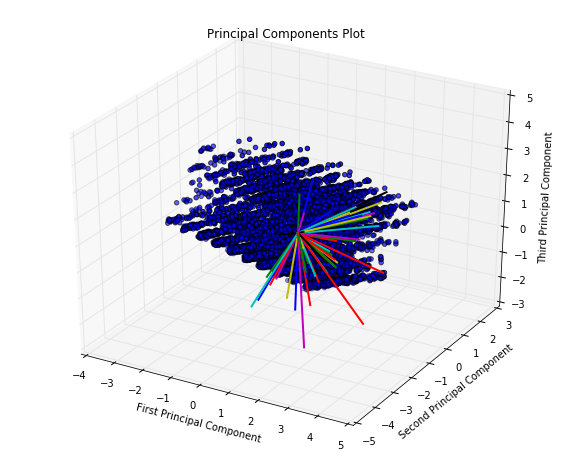

In [136]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
%matplotlib inline


scaled_pca = PCA(n_components=3).fit(scaled_data)
first_scaled_pc = [x*10 for x in scaled_pca.components_[0]]
second_scaled_pc = [y*10 for y in scaled_pca.components_[1]]
third_scaled_pc = [z*10 for z in scaled_pca.components_[2]]

scaled_pcs = [first_scaled_pc, second_scaled_pc, third_scaled_pc]

# plot in 3d
def plot_pc_data(features, scaled_pcs):
    x = features[:, 0]
    y = features[:, 1]
    z = features[:, 2]
    
    fig = pl.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Principal Components Plot")
    
    # plotting data points
    ax.scatter(x, y, z, 'k.')
    # plotting pc vectors
    for i, j in enumerate(original_data.columns):
        ax.plot(xs=[0, scaled_pcs[0][i]], ys=[0, scaled_pcs[1][i]], zs=[0, scaled_pcs[2][i] ], lw=2, label=j)
#         ax.annotate(range(0, len(original_data.columns)), 
#                     (scaled_pcs[0][i], scaled_pcs[1][i], scaled_pcs[2][i]), 
#                     label=j, markersize=2)
        
    ax.set_xlabel("First Principal Component")
    ax.set_ylabel("Second Principal Component")
    ax.set_zlabel("Third Principal Component")
    
    ax.auto_scale_xyz(x, y, z)
    pl.show()

# use data reduced down to three dimensions
plot_pc_data(reduced_scaled_data, scaled_pcs)

# Cross Validation

In [110]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(cleaned_features, label, test_size=0.2, random_state=12)

scorer = make_scorer(f1_score)
cv_algo = KFold(n=max(*cleaned_features.shape), n_folds=10, shuffle=True, random_state=12)

cvs = cross_val_score(estimator=RandomForestClassifier(),
                      X=cleaned_features.as_matrix(),
                      y=label[label.columns[0]],
                      scoring=scorer,
                      cv=cv_algo)

print cvs.mean()

SyntaxError: invalid syntax (<ipython-input-110-c855ca157437>, line 5)

# Classification

In [ ]:
# features, pd.DataFrame(label)
from sklearn.svm import SVC

clf = SVC(C=0.1, gamma=0.1)

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

pred = clf.predict(X_test)
t3 = time.time()

print "Training time: {}".format(t2 - t1)
print "Prediction time: {}".format(t3 - t2)
print "F1 Score: {}".format(f1_score(y_test, pred))

In [ ]:
clf = SVC()

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

pred = clf.predict(X_test)
t3 = time.time()

print "Training time: {}".format(t2 - t1)
print "Prediction time: {}".format(t3 - t2)
print "F1 Score: {}".format(f1_score(y_test, pred))

# The following GridSearchCV algorithm will take up to 30 minutes to run

It's not necessary to run, as it will yield the same f1 score as the classifier above.

In [674]:
# # I'd like to explore the parameter combinations of the svm classifier to analyze any significant increase in the F1 score
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import make_scorer

# scorer = make_scorer(f1_score)
# params = {'C': [0.1*c for c in range(1,3)],
#           'gamma': [0.1*g for g in range(1,5)]}

# clf = SVC()
# clf.fit(X_train, y_train)

# gs_svm = GridSearchCV(clf, param_grid=params, scoring=scorer)
# # must fit 
# gs_svm.fit(features, label[label.columns[-1]])

# print gs_svm.best_estimator_
# print gs_svm.best_score_
# print gs_svm.best_params_

In [431]:
print scaled_data.shape
print cleaned_features.shape

(36197, 57)
(36197, 57)


# The classifier is working way too well, with an f1 score of .999

I'm going to fit the data with a decision tree and check which features have been 

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

rfc = RandomForestClassifier()
xrfc = ExtraTreesClassifier()

t1 = time.time()
rfc.fit(X_train, y_train)
t2 = time.time()

rfc_pred = rfc.predict(X_test)
t3 = time.time()

xrfc.fit(X_train, y_train)
t4 = time.time()

xrfc_pred = xrfc.predict(X_test)
t5 = time.time()

rfc_f1 = f1_score(y_test, rfc_pred)
xrfc_f1 = f1_score(y_test, xrfc_pred)

print "Training time: {}".format(t2 - t1)
print "Prediction time: {}".format(t3 - t2)
print "F1 Score: {}\n".format(rfc_f1)
print "Training time: {}".format(t4 - t3)
print "Predictino time: {}".format(t5 - t4)
print "F1 Score (ExtraTrees): {}".format(xrfc_f1)

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training time: 0.671561002731
Prediction time: 0.0340671539307
F1 Score: 0.532728379027

Training time: 0.778571844101
Predictino time: 0.0342571735382
F1 Score (ExtraTrees): 0.532724821758


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

In [112]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
# mnb.fit(cleaned_features, label[label.columns[-1]])
mnb.fit(X_train, y_train)

nb_pred = mnb.predict(X_test)

f1_nb = f1_score(y_test, nb_pred)

print f1_nb

0.522221554277


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


## Random Forests is a lot quicker. I'd like to hypertune the parameters and try to beat the svm classifier's score

## I might use Spark to run the svm's grid search algorithm

In [113]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# param ranges were narrowed down from original, but still within range of the best estimator,
# in order to reduce gridsearch algorithm running time
a = time.time()
params = {'n_estimators': range(10, 15),
          'criterion': ['gini', 'entropy'],
          'min_samples_split': range(1, 5),
          'min_samples_leaf': range(5, 10)}
scorer = make_scorer(f1_score)
est = RandomForestClassifier()
est.fit(X_train, y_train)

gs = GridSearchCV(est, param_grid=params, scoring=scorer)
gs.fit(features, label[label.columns[-1]])

print gs.best_estimator_
print gs.best_score_
print gs.best_params_
print "Running time: {}".format(time.time() - a)

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ValueError: could not convert string to float: Full-stack web developer

In [114]:
# input the optimal parameters into the classifier
rfc = RandomForestClassifier(min_samples_split=1, 
                             n_estimators=13, 
                             criterion='entropy', 
                             min_samples_leaf=7)

t1 = time.time()
rfc.fit(X_train, y_train)
t2 = time.time()
hypertuned_rfc_pred = rfc.predict(X_test)
t3 = time.time()

rfc_f1 = f1_score(y_test, hypertuned_rfc_pred, pos_label=1)
print "Training time for {}: {}".format(class_name(rfc), t3 - t2)
print "Prediction time: {}".format(t2 - t1)
print "F1 Score: {}".format(rfc_f1)

# analyze the most important features that help make the best predictions
rfc_fi_ = pd.Series(rfc.feature_importances_, index=cleaned_features.columns)
rfc_fi_ = rfc_fi_.sort_values(ascending=False)

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training time for RandomForestClassifier: 0.0198888778687
Prediction time: 0.444306135178
F1 Score: 0.51672171993


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [667]:
all_scores = []
for i in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(cleaned_features, label, test_size=0.2, random_state=i)

    rfc = RandomForestClassifier(min_samples_split=1, 
                             n_estimators=13, 
                             criterion='entropy', 
                             min_samples_leaf=7)

    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_test)
    f1 = f1_score(y_test, pred)
    all_scores.append(f1)
    
print "Stats of 20 samples:"
print "Mean: {}".format(np.mean(all_scores))
print "Standard Deviation: {}".format(np.std(all_scores))

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Applications/Code/anaconda/lib/python2.7/site-packa

Stats of 20 samples:
Mean: 0.884896406187
Standard Deviation: 0.00288665539746


I ran into the problem that the classifier had a low recall for the positive and negative scores. It had a very high precision.

[[ 0.952  0.1  ]
 [ 0.283  0.053]]
0.999600920368
Confusion Matrices for RF, hypertuned-RF, and SVM, respectively


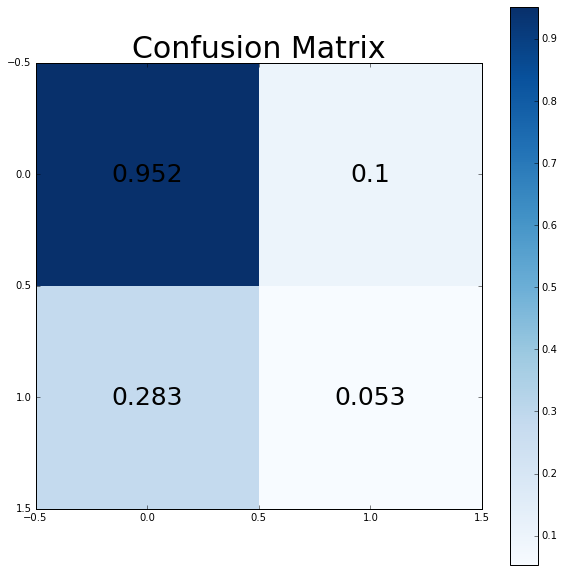

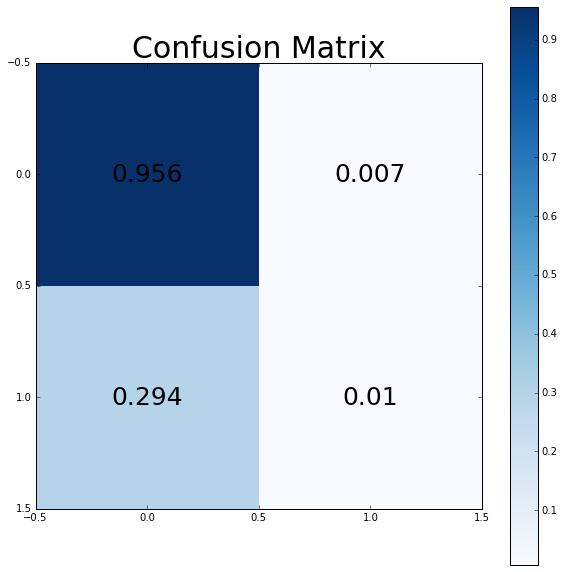

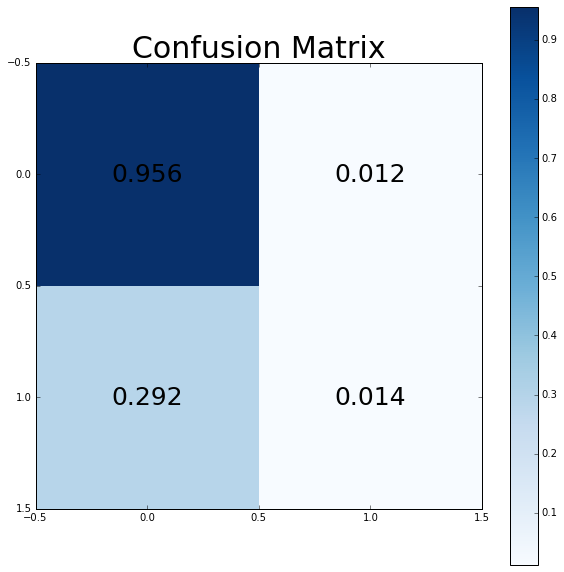

In [116]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from numpy.linalg import norm
%matplotlib inline

# copied and pasted then modded from stackoverflow question to obtain
def perf_measure(y_actual, y_hat):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    
    for i in range(len(y_hat)):
        if y_actual[i][0] == y_hat[i] == 1:
            tp += 1
        elif y_actual[i][0] == 1 and y_actual[i][0] != y_hat[i]:
            fp += 1
        elif y_actual[i][0] == 0 and y_actual[i][0] != y_hat[i]:
            fn += 1
        elif y_actual[i][0] == y_hat[i] == 0:
            tn += 1
            
    return (tp, fp, fn, tn)


def normalized_confusion_matrix(cm):
    total = norm(cm)
    result = cm.tolist()
    
    row = 0
    for row_elements in cm:
        col = 0
        for col_element in row_elements:
            result[row][col] = round(float(col_element) / float(total), 3)
            col += 1
        row += 1
        
    return np.array(result)


cm_rf = normalized_confusion_matrix(confusion_matrix(y_test, rfc_pred, labels=[1, 0]))
cm_rf_ht = normalized_confusion_matrix(confusion_matrix(y_test, hypertuned_rfc_pred, labels=[1, 0]))
# cm_svm = normalized_confusion_matrix(confusion_matrix(y_test, pred, labels=[1, 0]))
cm_nb = normalized_confusion_matrix(confusion_matrix(y_test, nb_pred, labels=[1, 0]))

print cm_rf
print norm(cm_rf)


def plot_confusion_matrix(cm, cmap=pl.cm.Blues):
    pl.figure(figsize=(10, 10))
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title("Confusion Matrix")
    pl.colorbar()
    pl.title("Confusion Matrix", size=30)
    for x in range(0,2):
        for y in range(0, 2):
            pl.annotate(str(cm[x][y]), xy = (y, x),
                        horizontalalignment='center', 
                        verticalalignment='center',
                        size=25)

print "Confusion Matrices for RF, hypertuned-RF, and SVM, respectively"
plot_confusion_matrix(cm_rf)
plot_confusion_matrix(cm_rf_ht)
# plot_confusion_matrix(cm_svm)
plot_confusion_matrix(cm_nb)

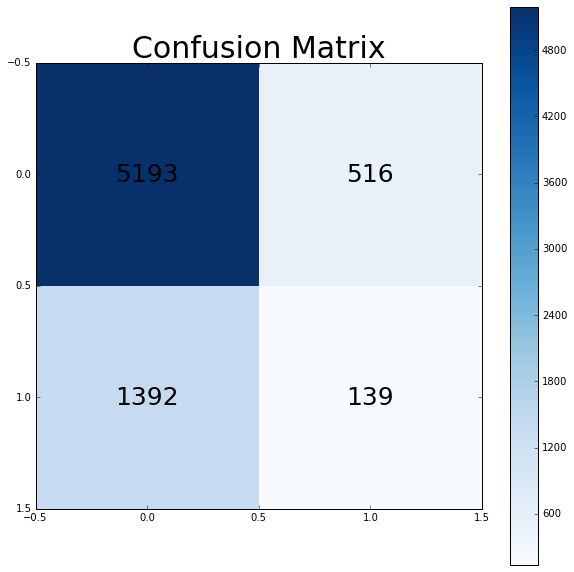

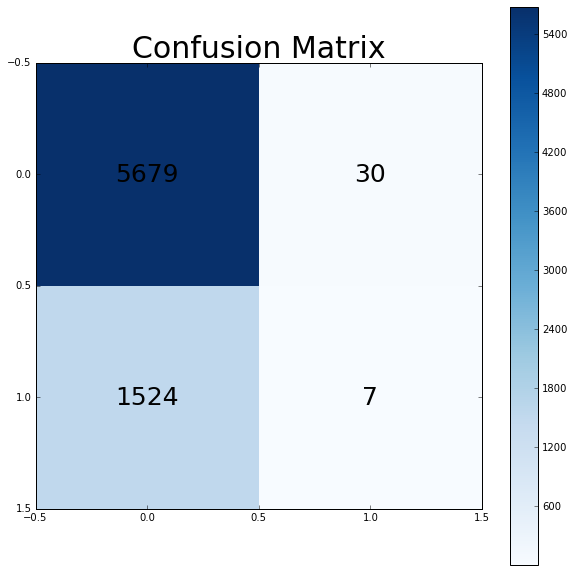

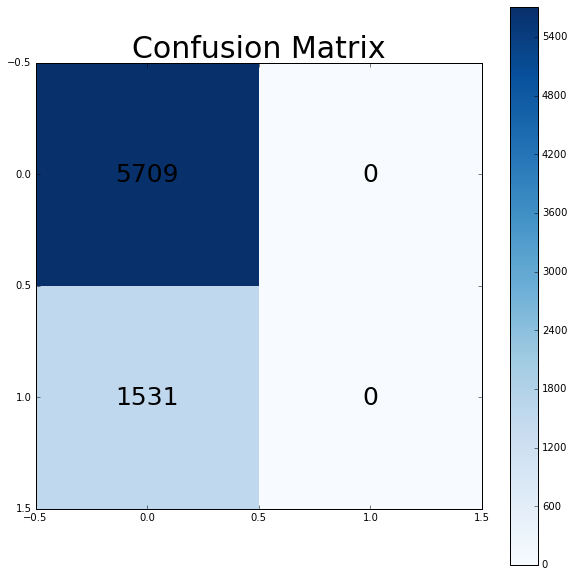

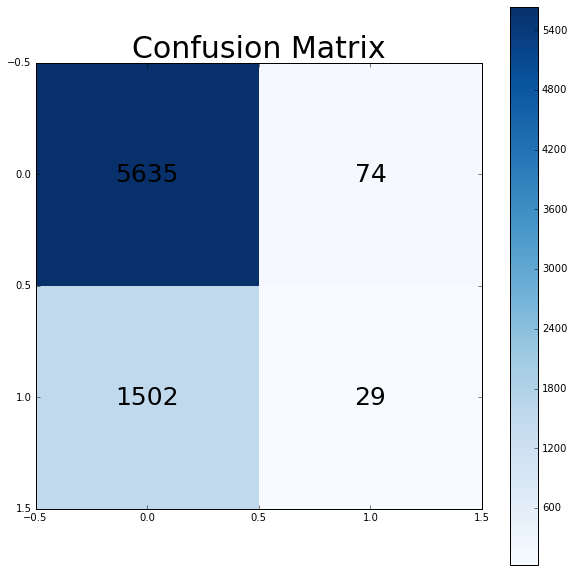

In [672]:
plot_confusion_matrix(confusion_matrix(y_test, rfc_pred, labels=[1, 0]))
plot_confusion_matrix(confusion_matrix(y_test, hypertuned_rfc_pred, labels=[1, 0]))
plot_confusion_matrix(confusion_matrix(y_test, pred, labels=[1, 0]))
plot_confusion_matrix(confusion_matrix(y_test, nb_pred, labels=[1, 0]))

In [676]:
# Create graph of ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

fpr = dict()
tpr = dict()
roc_auc = dict()

clf = OneVsRestClassifier(SVC(C=0.1, gamma=0.1))
y_score = clf.fit(X_train, y_train).decision_function(X_test)



for i in range(0, 2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

TypeError: unhashable type

In [617]:
binary_clf = {}

for i in y_test[y_test.columns[-1]]:
    if i not in binary_clf:
        binary_clf[i] = 1
    else:
        binary_clf[i] += 1

print binary_clf

print float(1531) / (1531+5709)

{0: 1531, 1: 5709}
0.211464088398


In [581]:
# calculating the percentages in the confusion matrix
for row in cm_rf:
    for col in row:
        print float(col) / 10000

0.5218
0.0491
0.1389
0.0142


In [498]:
from sklearn.metrics import classification_report

print "Random Forest:"
print classification_report(y_test, rfc_pred, labels=[1, 0])
print cm_rf
print "\nRandom Forest Hypertuned:"
print classification_report(y_test, hypertuned_rfc_pred, labels=[1, 0])
print cm_rf_ht
print "\nSupport Vector Machine:"
print classification_report(y_test, pred, labels=[1, 0])
print cm_svm

Random Forest:
             precision    recall  f1-score   support

          1       0.79      0.91      0.85      5709
          0       0.22      0.09      0.13      1531

avg / total       0.67      0.74      0.70      7240

[[5357  413]
 [1250  220]]

Random Forest Hypertuned:
             precision    recall  f1-score   support

          1       0.79      0.99      0.88      5709
          0       0.20      0.01      0.01      1531

avg / total       0.66      0.78      0.70      7240

[[5752   18]
 [1433   37]]

Support Vector Machine:
             precision    recall  f1-score   support

          1       0.79      1.00      0.88      5709
          0       0.50      0.01      0.03      1531

avg / total       0.73      0.79      0.70      7240

[[5770    0]
 [1470    0]]


In [677]:
print "Feature importances:\n\n{}".format(rfc_fi_[:10])

Feature importances:

agree_loveboss              0.106145
age_range                   0.048993
programming_ability         0.048135
experience_range            0.040450
important_promotion         0.036851
important_companymission    0.029022
important_wfh               0.027518
important_control           0.024915
important_variety           0.024319
important_buildexisting     0.024226
dtype: float64


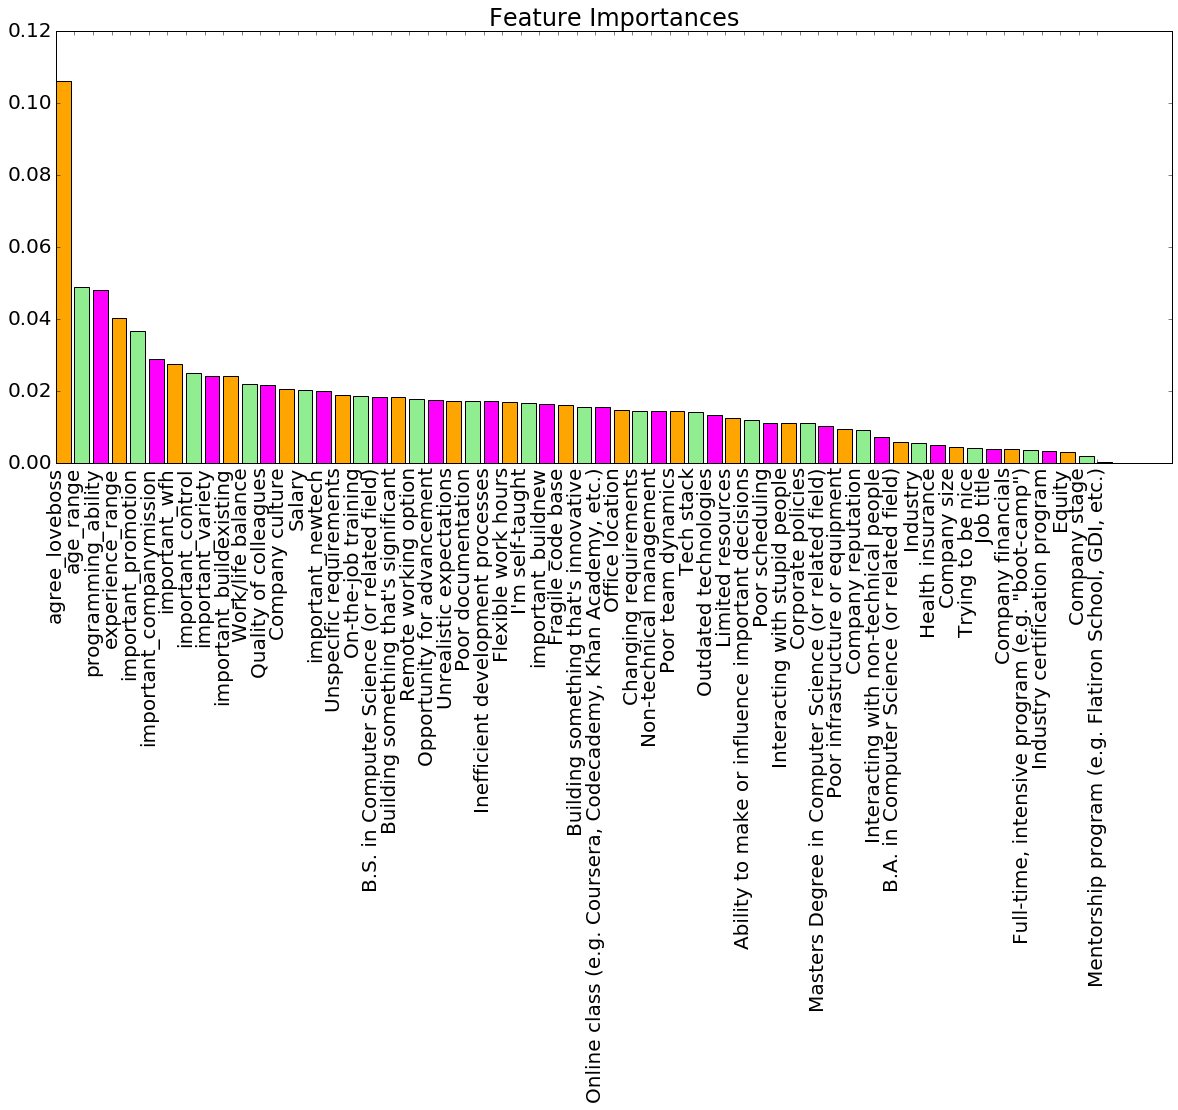

In [719]:
# plotting feature importances in descending order
pl.figure(figsize=(20,8))
pl.title("Feature Importances", size=24)
pl.bar(np.arange(len(rfc_fi_.index)),
       rfc_fi_.values,
       color=('orange', 'lightgreen', 'magenta'),
       tick_label=list(rfc_fi_.index))
pl.xticks(np.arange(len(rfc_fi_.index)), list(rfc_fi_.index), rotation='vertical', fontsize=20)
pl.yticks(size=20)
pl.subplots_adjust(bottom=0.15)

In [422]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
params = {'booster': 'gbtree', 'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

tree_booster_params = {'eta': 1, 'gamma': 1, 'min_child_weight': 1, 'max_depth': 3}
watchlist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 3
bst = xgb.train(params, dtrain, num_boost_round=num_round)
preds = bst.predict(dtest)
labels = dtest.get_label()

print sorted(bst.get_fscore().items(), key=lambda t: -t[1])
print ('error=%f' % ( sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# dtrain.feature_names

# help('xgboost.DMatrix')

[('agree_loveboss', 5), ('Remote working option', 2), ('important_newtech', 1), ('important_promotion', 1)]
error=0.203591


In [308]:
# Here, I'd like to visualize the number of different answers for each column
# I'd like to make a subplot for each column after cleaning, and look at the data by frequency
cols = df.columns
total_cols = len(cols)

col_data_dict = {}
# leaving out cols[0] because it is an ID column
for col, data in df[cols[1:]].iteritems():
    print df[col].groupby(df[col]).count()

collector
Facebook                     9811
House ads                    8633
Meta Stack Overflow Post    28177
Miscellaneous                 108
Reddit                       6226
Twitter                      3075
dtype: int64
country
Afghanistan                48
Albania                    34
Algeria                    38
Andorra                    12
Angola                     10
Antarctica                  1
Antigua & Deps              2
Argentina                 362
Armenia                    35
Australia                1117
Austria                   482
Azerbaijan                 29
Bahamas                     7
Bahrain                    11
Bangladesh                166
Barbados                    3
Belarus                   164
Belgium                   543
Belize                      2
Benin                       2
Bermuda                     2
Bhutan                      2
Bolivia                    15
Bosnia Herzegovina         54
Botswana                    4
Brazil         

## The following columns need to be broken down:

'self_identification'

'tech_do'

'tech_want'

'dev_environment'

'education'

'new_job_value'

'how_to_improve_interview_process'

'developer_challenges'

'why_stack_overflow'

## Removing NaN entries
There are multiple ways to remove NaN entries.
One way to remove NaN values is with the .dropna() function. However, this function can remove too many values, so I looked at the percentage decrease of data by using this function. The sklearn.preprocessing.Imputer function won't work for the label column.

In [37]:
# we'll break down education and take a look at it here
def plot_axes(df, column_name):
    if df.__class__.__name__ == 'DataFrame':
        bernoulli_df_sum = convert_to_bernoulli_columns(df, column_name).sum()
    elif df.__class__.__name__ == 'Series':
        bernoulli_df_sum = df
        
    bernoulli_df_sum.sort_values(inplace=True, 
                                 ascending=False,
                                 na_position='first')
    x = bernoulli_df_sum.index
    y = bernoulli_df_sum
    
    return x, y, column_name

def plot_bernoulli_df((x, y, column_name)):
    
    ind = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical')
    pl.subplots_adjust(bottom=0.15)
    pl.show()
    
edu_sum = convert_to_binary_columns(df, 'education').sum()

## Need to recombine the expanded columns into the original dataset

The original dataset should have (12 + 42 + 42 + 23 + 12 + 20 + 9 + 16 + 10 - 9) more columns.

In [11]:
edu_df = convert_to_bernoulli_columns(df, 'education')

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.mixture import GMM

pipe_lr = Pipeline([("scl", StandardScaler()),
                    ("pca", PCA()),
                    ("gmm", GMM())
                ])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('gmm', GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))])

In [190]:
# Reduce the data into the necessary amount of dimensions
# Scale the data to find a correlation among the variables
pipe_lr.score(X_test, y_test)

array([-80.89847253, -74.32967353, -71.61493557, ..., -76.54780089,
       -90.40464955, -70.81135511])

# The Target/Label column(s)

First, we have to categorize the target column(s):

Is it a single column or multiple columns?

Is it a classification or regression?


In [87]:
# for the target column we need to vectorize it
# the target column is also

sw_vs_st = df['star_wars_vs_star_trek']


def transform_labels(target_col):
    le = LabelEncoder()
    le.fit(target_col)
    return le.transform(target_col)


def transform_labels_except_nan(target_col):
    print target_col.shape
    mapper = {"Star Wars": 1,
              "Star Trek": 2,
              "Star Wars; Star Trek": 3}
    
    target_col = target_col.map(mapper)
    print target_col.shape
    return target_col

vectorized_target_col = transform_labels(sw_vs_st)

imr = Imputer(missing_values=0, strategy="median", axis=1)
vectorized_target_col = imr.fit_transform(vectorized_target_col)
vectorized_target_col = vectorized_target_col[0]
vectorized_target_col = pd.DataFrame(vectorized_target_col)

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [88]:
# Merge feature and label columns
edu_sw_st = pd.concat([edu_df, vectorized_target_col], axis=1)
edu_sw_st = edu_sw_st.dropna()

## How do we deal with NaN entries and multiclass labels?

In [198]:
# Let's test an ML algorithm to predict the language a person is using, based on the dev environment
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# I'm using SVM because it is still effective with a high number of features, sometimes even when the number of features
# is greater than the number of samples
# Use Random Forests
# Use Gradient Boosting

# X = edu_sw_st[edu_sw_st.columns[:min(*edu_sw_st.shape) - 1]]
# y = edu_sw_st[edu_sw_st.columns[-1]]

def train_clf(clf, X_train, y_train):
    a = time.time()
    clf.fit(X_train, y_train)
    b = time.time()
    
    print "Training time for {}: {}".format(clf.__class__.__name__, b - a)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# clf = SVC(kernel='poly',
#           degree=4,
#           gamma=0.3,
#           C=)

# train_clf(clf, X_train, y_train)

In [212]:
def prediction(clf, X_test, y_test):
    a = time.time()
    pred = clf.predict(X_test)
    b = time.time()
    print "Prediction time in seconds: {}".format(b - a)
    return f1_score(y_test, pred)

prediction(clf, X_test, y_test)

Prediction time in seconds: 0.360489845276


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


1.0

In [115]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, n_folds=5)

In [135]:
train_indices, test_indices = next(iter(skf))

X_train, y_train = X.iloc[train_indices], y[train_indices]
X_test, y_test = X.iloc[test_indices], y[test_indices]

clf = SVC()

train_clf(clf, X_train, y_train)


Training time for SVC: 63.1962859631


In [137]:
prediction(clf, X_test, y_test)

Prediction time in seconds: 3.62956309319


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.6918835503435915

In [152]:
# Let's try KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

params = {'n_neighbors': range(5, 11),
          'weights': ['distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
          }
scorer = make_scorer(f1_score)
knc = KNeighborsClassifier()
gs = GridSearchCV(estimator=knc, 
                  param_grid=params,
                  scoring=scorer)
c = time.time()
gs.fit(X, y)
print "Grid Search time in seconds: {}".format(time.time() - c)

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10], 'weights': ['distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(f1_score),
       verbose=0)

## The prediction resulted worse than expected.

First: I'll see if there's a more appropriate metric, other than f1_score

Second: I'll need to first check if the parameters need tuning


In [304]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe_lr = Pipeline(['scl', StandardScaler(),
                   'clf', SVC()])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)


# skf = KFold(max(*X.shape), n_folds=5, shuffle=True, random_state=12)
# for train, test in skf:
#     print train, test

TypeError: zip argument #2 must support iteration

In [106]:
# problem: Target column includes 4 answers: SW, ST, SW+ST, NaN
# prediction Needs to either be binary or multivariable
